<hr style="border:2px solid gray">

##### Author  : SIVA VIKNESH & YOUNES TATARI
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com , younes.tatari@utah.edu/ younes.tatari@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA 
<hr style="border:2px solid gray">

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import math
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True, precision=15)

ABC Flow
Paper: 


The flow differential equations are:

U component of the velocity
$$
\dot{x} = Asin(w1z) +Ccos(w2y)
$$
V component of the velocity
$$
\dot{y} = Bsin(w3x) + Acos(w4z)
$$

W component of the velocity
$$
\dot{z} = Csin(w5y) + Bcos(w6x)
$$


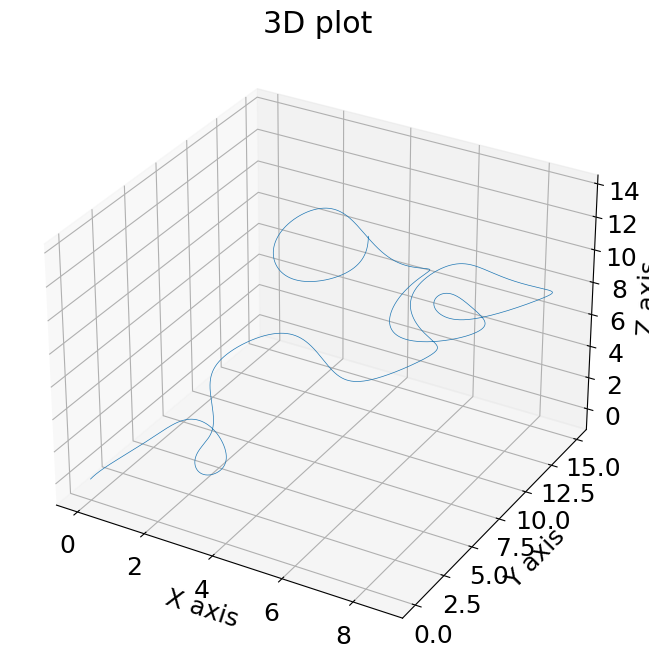

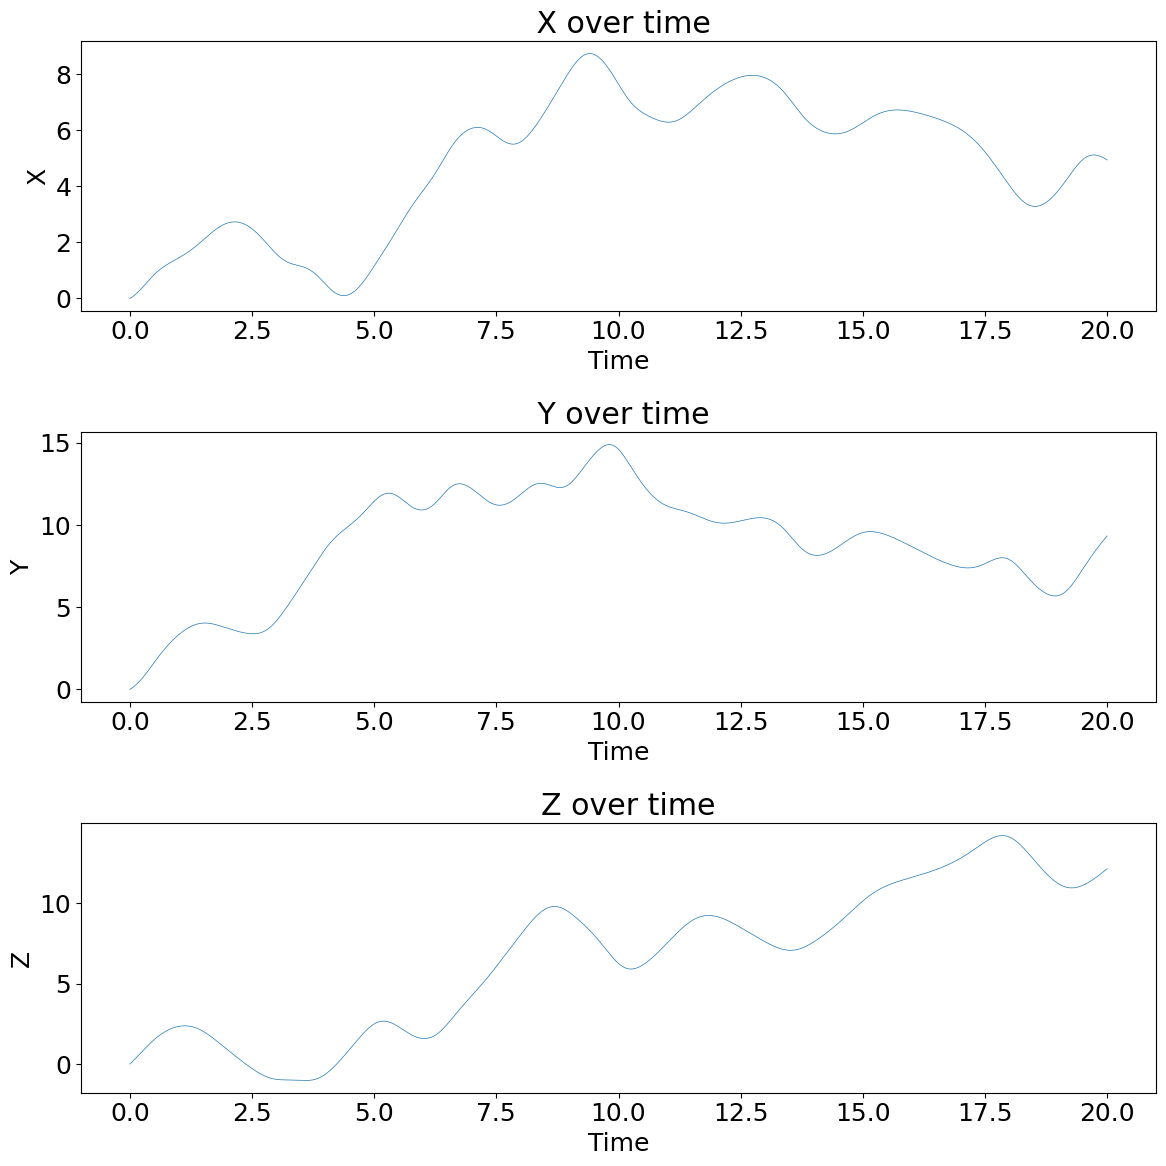

In [2]:
# Parameters 
A = 2.0
B = 3.0
C = 1.0

w1 =  np.pi/4.0
w2 =  np.pi/3.0
w3 =  np.pi/2.0
w4 =  np.pi/5.0
w5 =  np.pi/4.5
w6 =  np.pi/2.8


def deriv(X, t, A , B , C, w1, w2, w3,w4,w5,w6):
    x, y, z = X
    dxdt = A*np.sin(w1*z) + C*np.cos(w2*y) 
    dydt = B*np.sin(w3*x) + A*np.cos(w4*z) 
    dzdt = C*np.sin(w5*y) + B*np.cos(w6*x) 
    return [dxdt, dydt, dzdt]

# Initial conditions
X0 = [0.0, 0.0, 0.0]

# Time points
t = np.linspace(0, 20, 10000)

# Integrate the equations
X = odeint(deriv, X0, t, args=(A, B, C,w1, w2, w3,w4,w5,w6))

# Extract the results
x = X[:, 0]
y = X[:, 1]
z = X[:, 2]

# Plotting the results
fig = plt.figure(figsize=(12, 8))

# 3D plot of the Lorenz attractor
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5)
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
ax.set_title("3D plot")

# Show plot
plt.show()

# 2D plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

ax1.plot(t, x, lw=0.5)
ax1.set_xlabel("Time")
ax1.set_ylabel("X")
ax1.set_title(" X over time")

ax2.plot(t, y, lw=0.5)
ax2.set_xlabel("Time")
ax2.set_ylabel("Y")
ax2.set_title(" Y over time")

ax3.plot(t, z, lw=0.5)
ax3.set_xlabel("Time")
ax3.set_ylabel("Z")
ax3.set_title("  Z over time")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


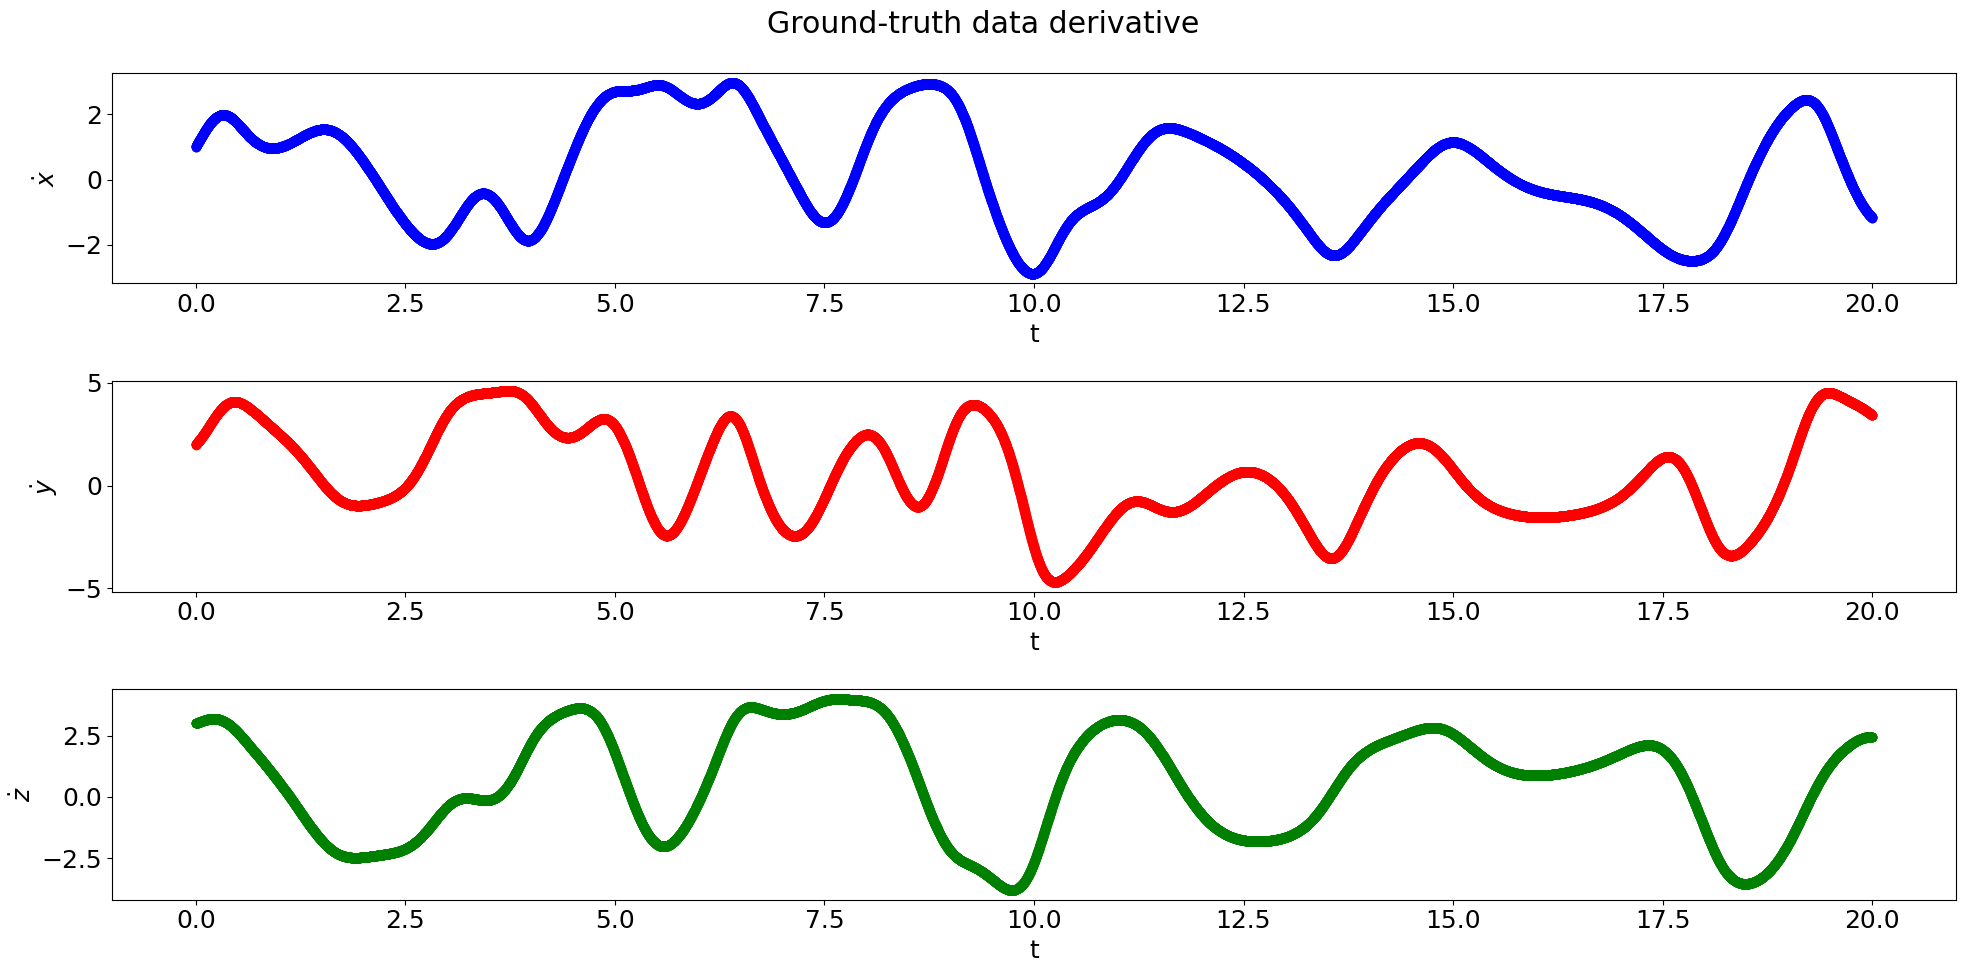

In [3]:
def DERIVATIVE(x, y, z, A,B,C,w1, w2, w3,w4,w5,w6):
    
    dxdt = A*np.sin(w1*z) + C*np.cos(w2*y) 
    dydt = B*np.sin(w3*x) + A*np.cos(w4*z) 
    dzdt = C*np.sin(w5*y) + B*np.cos(w6*x) 
    
    return np.vstack((dxdt, dydt, dzdt)).T

A1A2A3_time_deriv = DERIVATIVE (x, y, z, A,B,C,w1, w2, w3,w4,w5,w6)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
fig.suptitle('Ground-truth data derivative')

# Plot dS/dt
ax[0].plot(t, A1A2A3_time_deriv[:, 0], '-o', color='blue', linewidth=2)
ax[0].set(xlabel="t", ylabel="$\dot{x}$")

# Plot dI/dt
ax[1].plot(t, A1A2A3_time_deriv[:, 1], '-o', color='red', linewidth=2)
ax[1].set(xlabel="t", ylabel="$\dot{y}$")

# Plot dR/dt
ax[2].plot(t, A1A2A3_time_deriv[:, 2], '-o', color='green', linewidth=2)
ax[2].set(xlabel="t", ylabel="$\dot{z}$")

fig.tight_layout()
plt.show()

In [4]:
## SINDy Function Definitions
def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))

    # poly order 0
    yout[:,0] = np.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)

    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n): #Solves SINDy's L1 regularized convex optimization problem
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

In [5]:
N_frequency = 6
nums = [2,2.8,3,4,4.5,5]
modes = np.pi / np.array(nums)
print (modes)



# POLYNOMIAL TERMS
poly_candidate  = poolData(X, 3, 1)  
poly_candidate = poly_candidate [:, 1:] # IGNORING THE CONSTANT - FIRST COLUMN !!!

# FOURIER TERMS
Nsize = poly_candidate.shape[1] * N_frequency
sine_candidate = np.zeros((poly_candidate.shape[0], Nsize))
cos_candidate  = np.zeros((poly_candidate.shape[0], Nsize))

k = 0
for i in range (poly_candidate.shape[1]):
    for  j in range (N_frequency):
        sine_candidate [:, k] = np.sin(poly_candidate [:, i] * modes [j])
        cos_candidate  [:, k] = np.cos(poly_candidate [:, i] * modes [j])
        k += 1

# FOURIER TERMS * POLYNOMIAL TERMS
xsine_candidate = np.zeros((poly_candidate.shape[0], Nsize*poly_candidate.shape[1]))
xcos_candidate  = np.zeros((poly_candidate.shape[0], Nsize*poly_candidate.shape[1]))

k = 0
for i in range (Nsize):
    for  j in range (poly_candidate.shape[1]):
        xsine_candidate [:, k] = sine_candidate [:, i] * poly_candidate [:, j]
        xcos_candidate  [:, k] = cos_candidate  [:, i] * poly_candidate [:, j]
        k += 1


        
All_candidates       = np.hstack((poly_candidate, sine_candidate, cos_candidate, xsine_candidate, xcos_candidate))


[1.570796326794897 1.121997376282069 1.047197551196598 0.785398163397448
 0.698131700797732 0.628318530717959]



**Considering all the candidates in the optimization**

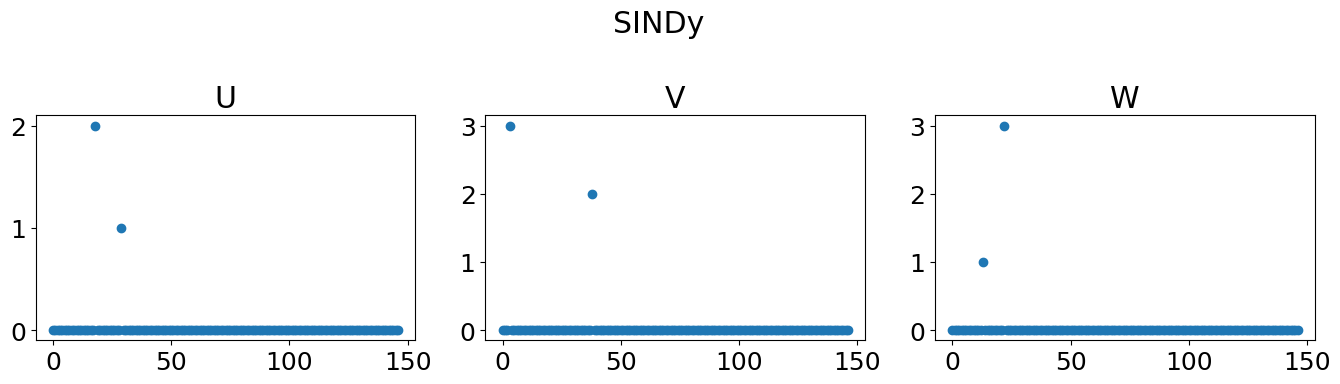

[[2.000000000000002 1.000000000000002]]
[[3.000000000000001 2.000000000000002]]
[[1.                2.999999999999999]]
(array([18, 29], dtype=int64),)
(array([ 3, 38], dtype=int64),)
(array([13, 22], dtype=int64),)


In [7]:
lamb = 0.03 # sparsification knob lambda
coeff_matrix = sparsifyDynamics(All_candidates, A1A2A3_time_deriv, lamb, 3)
#coeff_matrix = sparsifyDynamics(All_candidates, A1A2A3_time_deriv_sliced, lamb, 3)
#print(coeff_matrix)
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(14, 4))
fig.suptitle('SINDy')

ax[0].plot(coeff_matrix [:, 0], 'o') 
ax[0].set_title('U')


ax[1].plot(coeff_matrix [:, 1], 'o') 
ax[1].set_title('V')


ax[2].plot(coeff_matrix [:, 2], 'o') 
ax[2].set_title('W')


fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

print(coeff_matrix[np.nonzero(coeff_matrix[:, 0]), 0])
print(coeff_matrix[np.nonzero(coeff_matrix[:, 1]), 1])
print(coeff_matrix[np.nonzero(coeff_matrix[:, 2]), 2])
print(np.nonzero(coeff_matrix[:, 0]))
print(np.nonzero(coeff_matrix[:, 1]))
print(np.nonzero(coeff_matrix[:, 2]))